In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from utils import uv_to_wsd

INPUT_PATH = "../input/"

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 데이터 체크

In [2]:
# 터빈 개수가 적은 경주풍력에 대해서만 한번 진행
power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [3]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


In [4]:
tmp = pd.merge(power, ldaps,
               on = ['dt', 'turbine_id'])

tmp = pd.merge(tmp, gj_y[['dt', 'energy_kwh']],
               on = ['dt'])

tmp.head()

,dt,turbine_id,WTG.Serial,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],AvailabilityTechnicalStandbyTime[Min.],EnergyProductionActiveEnergyProduction[KWh],GeneratorAverageWindingTemp.[℃],...,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,energy_kwh
0,2020-01-02 00:00:00+09:00,WTG01,U113-001,0.0,10.0,0.0,0.0,0.0,380.859375,107.593384,...,10.059580,97974.593750,91.796478,0.002686,269.467560,0.021201,-0.375756,7.353266,-2.640615,17827.148438
1,2020-01-02 01:00:00+09:00,WTG01,U113-001,0.0,10.0,0.0,0.0,0.0,380.859375,107.803284,...,10.044404,97970.132812,91.729774,0.002686,269.430847,0.020706,-0.371947,7.578446,-2.414076,17616.210938
2,2020-01-02 02:00:00+09:00,WTG01,U113-001,0.0,10.0,0.0,0.0,0.0,381.835938,107.779114,...,10.478634,97951.546875,92.788666,0.002686,269.374390,0.020556,-0.354397,7.654554,-2.259913,17904.296875
3,2020-01-02 03:00:00+09:00,WTG01,U113-001,0.0,10.0,0.0,0.0,0.0,380.859375,107.875763,...,10.090029,97908.968750,92.494576,0.002686,269.352112,0.021635,-0.328609,7.275844,-2.280371,17676.757812
4,2020-01-02 04:00:00+09:00,WTG01,U113-001,0.0,10.0,0.0,0.0,0.0,379.882812,107.827988,...,9.672620,97858.398438,88.986443,0.002686,269.413269,0.024231,-0.265124,6.911751,-1.920128,18519.531250


In [5]:
tmp.columns = tmp.columns.str.replace("[", "_").str.replace("]", "")

In [6]:
tmp = tmp.drop(['turbine_id', 'WTG.Serial'], axis=1)

x_train = tmp.loc[tmp['dt'].between('2020-01-01', '2020-10-01', inclusive='left')].drop(['dt', 'energy_kwh'], axis=1)
x_test = tmp.loc[tmp['dt'].between('2020-10-01', '2021-01-01', inclusive='left')].drop(['dt', 'energy_kwh'], axis=1)

y_train = tmp.loc[tmp['dt'].between('2020-01-01', '2020-10-01', inclusive='left'), 'energy_kwh']
y_test = tmp.loc[tmp['dt'].between('2020-10-01', '2021-01-01', inclusive='left'), 'energy_kwh']

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6533, 39) (2208, 39) (6533,) (2208,)


In [12]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [13]:
xgb_params = {
    'tree_method': 'auto',
    # 'n_estimators': 1000,
    # 'max_depth': 8,
    'n_jobs': -1,
    'random_state': 1,
    'device': 'cuda'
}

xgb = XGBRegressor(**xgb_params)
xgb.fit(x_train, y_train)

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\xgboost\core.py:158: UserWarning: [14:32:13] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [14]:
y_pred = xgb.predict(x_test)

In [15]:
xgb.score(x_test, y_test)

0.8822563926895735

In [16]:
nmae = abs(y_pred-y_test)/20700*100
nmae = round(nmae.mean(), 2)
print(nmae)

7.63


c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


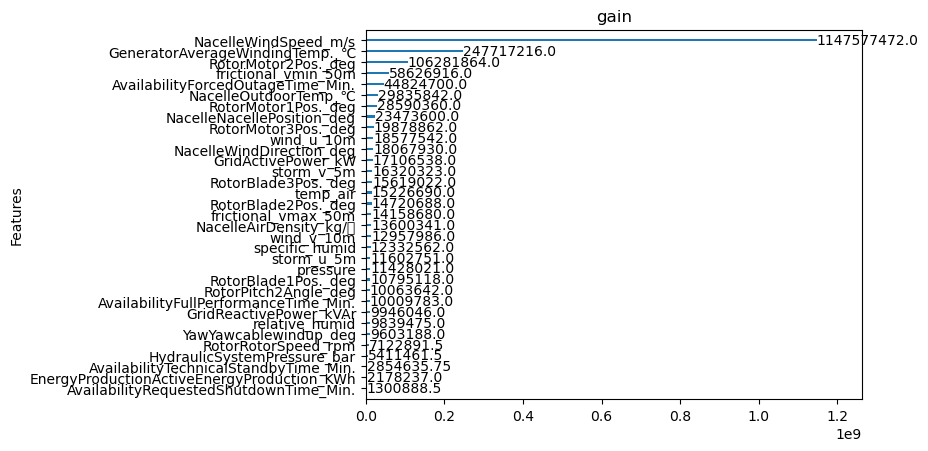

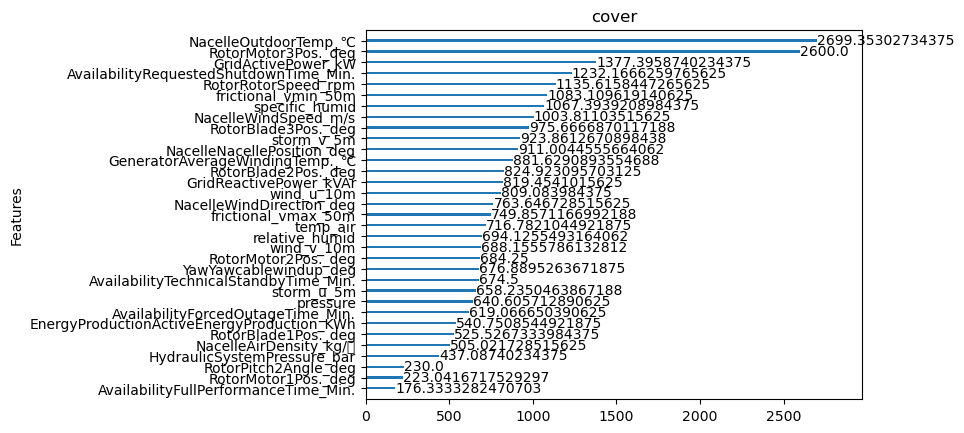

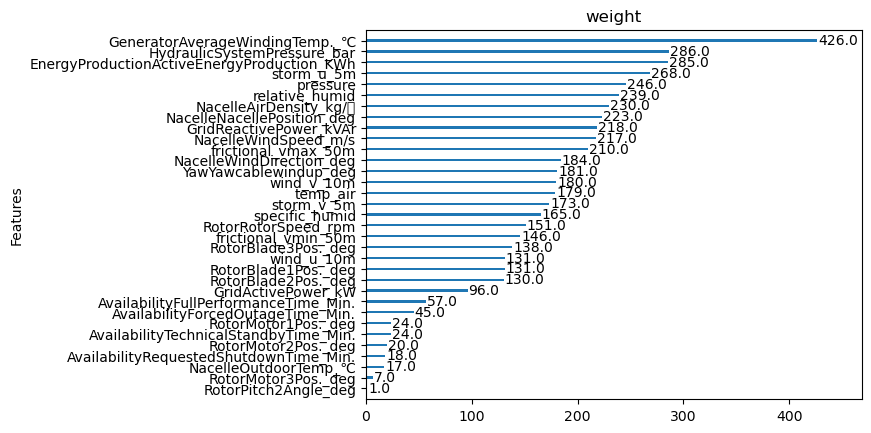

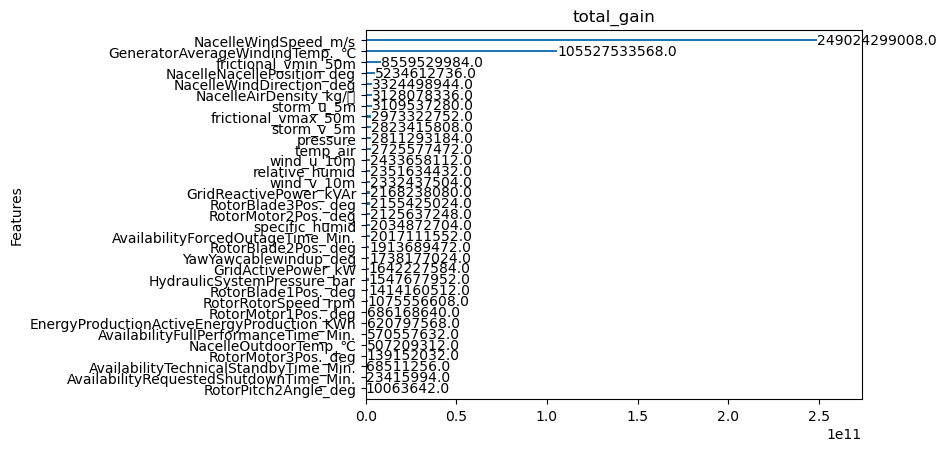

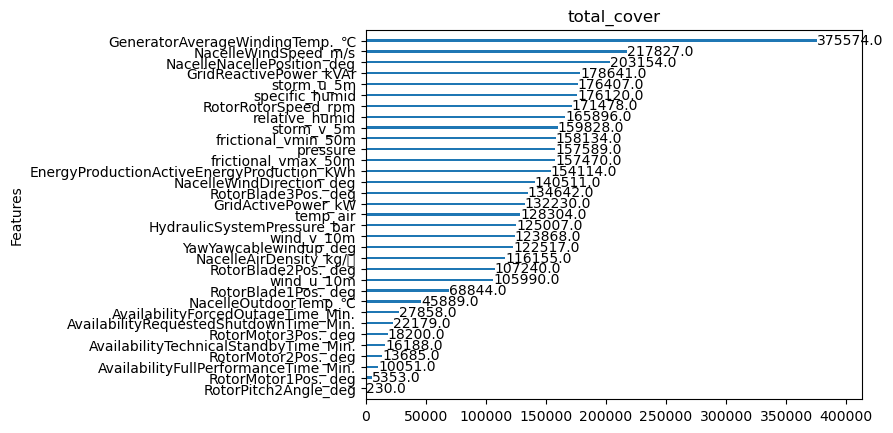

In [24]:
xgboost.plot_importance(xgb, importance_type='gain', title='gain', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='cover', title='cover', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='weight', title='weight', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='total_gain', title='total_gain', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='total_cover', title='total_cover', xlabel='', grid=False)

plt.show()

In [75]:
imp = pd.DataFrame(xgb.feature_importances_, columns=['imp'])
imp['col'] = xgb.feature_names_in_

display(imp.sort_values('imp', ascending=False))

,imp,col
14,0.580273,NacelleWindSpeed_m/s
6,0.125258,GeneratorAverageWindingTemp._℃
19,0.053741,RotorMotor2Pos._deg
30,0.029645,frictional_vmin_50m
0,0.022666,AvailabilityForcedOutageTime_Min.
12,0.015087,NacelleOutdoorTemp_℃
18,0.014457,RotorMotor1Pos._deg
11,0.011869,NacelleNacellePosition_deg
20,0.010052,RotorMotor3Pos._deg
37,0.009394,wind_u_10m
